<a href="https://colab.research.google.com/github/herzod/docker-your-first-project-4485003/blob/main/CNN_pytorch_TPMS_ServiceKits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import os
import time
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.6.0+cu124  Device: cpu


In [ ]:
# Define trainings parameter
num_classes = 13    # Muss y Tensor Dimension entsprechen
Batch_Size = 24
Learning_Rate = 0.001
Number_Epochs = 40         # Je höher, desto genauer
input_image_size = (128, 128)

In [ ]:
class SensorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        self.compat_map = {"Compatible": 0, "Incompatible": 1}
        self.class_maps = {"Compatible": {}, "Incompatible": {}}

        for compat_group in ["Compatible", "Incompatible"]:
            compat_path = os.path.join(root_dir, compat_group)
            if not os.path.isdir(compat_path):
                continue

            for class_name in sorted(os.listdir(compat_path)):
                class_path = os.path.join(compat_path, class_name)
                if not os.path.isdir(class_path):
                    continue

                # Map class names to indices per compat group
                if class_name not in self.class_maps[compat_group]:
                    self.class_maps[compat_group][class_name] = len(self.class_maps[compat_group])

                class_idx = self.class_maps[compat_group][class_name]
                compat_label = self.compat_map[compat_group]

                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(class_path, img_name)
                        self.samples.append((img_path, compat_label, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, compat_label, class_label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, compat_label, class_label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((input_image_size)),
    transforms.ToTensor()
])

train_dataset = SensorDataset('/content/drive/MyDrive/Colab Notebooks/Sensors/Train', transform=transform)
val_dataset = SensorDataset('/content/drive/MyDrive/Colab Notebooks/Sensors/Val', transform=transform)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, Batch_Size, shuffle=True)
val_loader = DataLoader(val_dataset, Batch_Size, shuffle=False)

In [ ]:
print(f'Total number of training examples: {len(train_dataset)}')
print(f'Total number of validation examples: {len(val_dataset)}')

Total number of training examples: 66
Total number of validation examples: 31


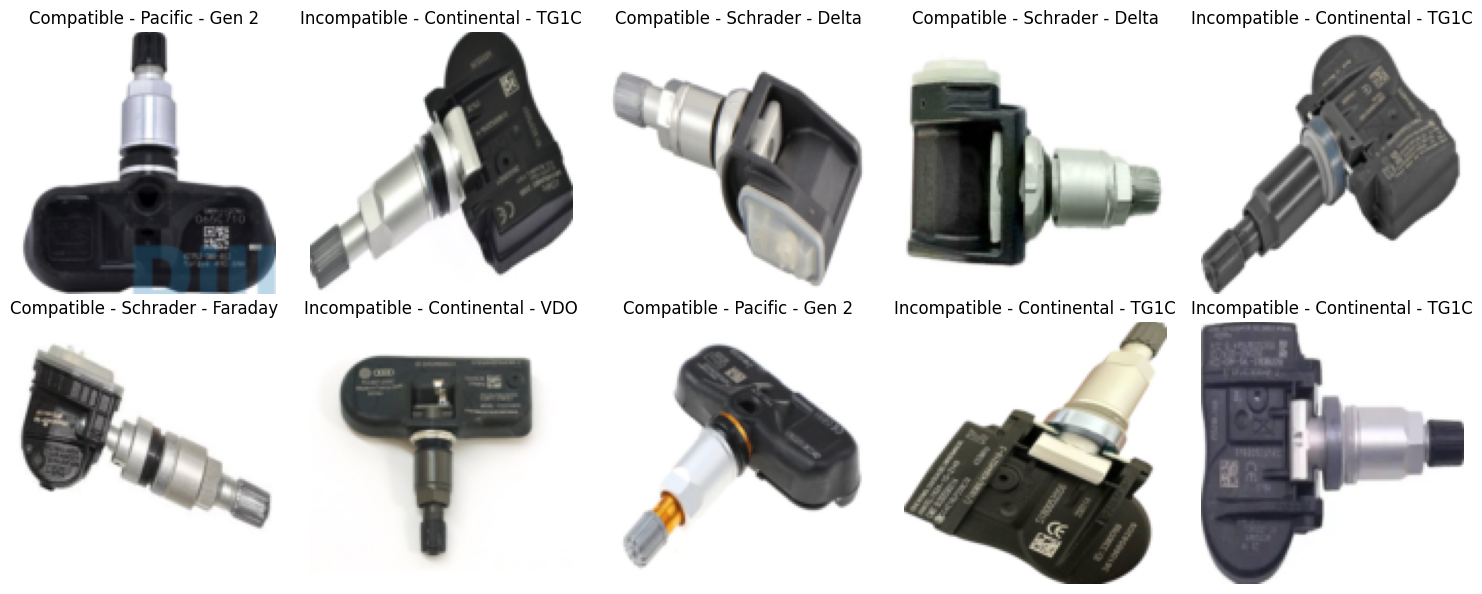

In [ ]:
# Get label mappings
compat_map = {0: "Compatible", 1: "Incompatible"}
class_map_compatible = {v: k for k, v in train_dataset.class_maps["Compatible"].items()}
class_map_incompatible = {v: k for k, v in train_dataset.class_maps["Incompatible"].items()}

# Shuffle indices and pick 10
random_indices = random.sample(range(len(train_dataset)), 10)

# Plotting
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    image, compat_label, class_label = train_dataset[idx]
    img_np = image.permute(1, 2, 0).numpy()

    # Get class name
    if compat_label == 0:
        class_name = class_map_compatible[class_label]
    else:
        class_name = class_map_incompatible[class_label]

    axes[i].imshow(img_np)
    axes[i].set_title(f"{compat_map[compat_label]} - {class_name}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution layers
        self.conv1 = nn.Conv2d(3, 20, 5, 1)  # Assuming 3 input channels (RGB)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)

        # Fully connected layers
        #Dynamically calculate input size for the first fully connected layer
        self.fc1 = nn.Linear(self._get_conv_output_size((3, 128, 128)), 500)
        self.dropout1 = nn.Dropout(0.5)

        # Output layer: 2 neurons for compatibility, 11 for class
        self.fc2 = nn.Linear(500, num_classes)  # 2+11 = 13 output neurons

    def _get_conv_output_size(self, input_size):
        """Calculates the output size of the convolutional layers."""
        # Create a dummy input tensor with the given input size
        dummy_input = torch.randn(1, *input_size)
        # Pass the dummy input through the convolutional layers to get the output size
        dummy_output = self.conv2(F.max_pool2d(self.conv1(dummy_input), 2, 2))
        dummy_output = F.max_pool2d(dummy_output, 2, 2)
        # Flatten the output and return the number of features
        return int(np.prod(dummy_output.size()[1:]))

    def forward(self, x):
        # Convolutional layers with ReLU activation and MaxPool
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)  # Pooling after conv1

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)  # Pooling after conv2

        # Calculate the correct flattened size dynamically
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x)) # This is where the error happens
        x = self.dropout1(x)

        # Output layer with 13 output neurons
        x = self.fc2(x)

        # Softmax for both outputs (compatibility + class)
        return F.softmax(x, dim=1)  # Softmax across the 13 output neurons

In [ ]:
model = ConvNet().to(device) #ConvNet(): Leere Klammer weil oben bei Self keine Argumente definiert wurden "def __init__(self):""
model

ConvNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=42050, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=13, bias=True)
)

In [ ]:
# Loss Function vorgeben
criterion = nn.CrossEntropyLoss()

In [ ]:
# Optimizer vorgeben (SGD Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(), lr = Learning_Rate) #OPtimizer SGD oder ADAM

In [ ]:
def train(epoch, loss_values, log_interval=1):
    running_loss = 0
    start_time = time.time()  # Record the start time of the epoch

    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    for batch_idx, (X_train, y_train_compat, y_train_class) in enumerate(train_loader): # train_loader returns compatibility and class labels
        # Copy data to GPU if needed
        X_train = X_train.to(device)
        y_train_compat = y_train_compat.to(device)
        y_train_class = y_train_class.to(device)

        # Forward Propagation
        y_pred = model(X_train)  # Output from model (13 values per sample)

        # Split the output: first 2 values are for compatibility, the rest are for class prediction
        y_pred_compat = y_pred[:, :2]  # First 2 values for compatibility prediction
        y_pred_class = y_pred[:, 2:]   # Remaining 11 values for class prediction

        # Zero gradient buffers
        optimizer.zero_grad()

        # Calculate loss for compatibility and class prediction
        loss_compat = criterion(y_pred_compat, y_train_compat)  # Compatibility loss
        loss_class = criterion(y_pred_class, y_train_class)    # Class prediction loss

        # Total loss is the sum of both losses
        total_loss = loss_compat + loss_class

        # Backpropagate
        total_loss.backward()

        # Update weights
        optimizer.step()

        if batch_idx % log_interval == 0:
            # Print training progress and estimated remaining time
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X_train), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), total_loss.item()))

        running_loss += total_loss.item()

    running_loss /= len(train_loader)
    loss_values.append(running_loss)


In [ ]:
def validate(epoch, loss_values, accuracy_values):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradient calculation
        val_loss, correct_compat, correct_class = 0, 0, 0

        for X_val, y_val_compat, y_val_class in val_loader:  # Assuming val_loader returns compatibility and class labels
            X_val = X_val.to(device)
            y_val_compat = y_val_compat.to(device)
            y_val_class = y_val_class.to(device)

            # Forward propagation
            y_pred = model(X_val)  # Model output: [batch_size, 13]

            # Split the predictions
            y_pred_compat = y_pred[:, :2]  # First 2 values: compatibility prediction
            y_pred_class = y_pred[:, 2:]   # Next 11 values: class prediction

            # Compute loss for compatibility and class
            loss_compat = criterion(y_pred_compat, y_val_compat)
            loss_class = criterion(y_pred_class, y_val_class)

            # Total loss: sum of compatibility and class losses
            total_loss = loss_compat + loss_class
            val_loss += total_loss.item()

            # Get the predicted classes for compatibility and class prediction
            pred_compat = y_pred_compat.data.max(1)[1]  # Max probability for compatibility
            pred_class = y_pred_class.data.max(1)[1]    # Max probability for class

            # Calculate correct predictions
            correct_compat += pred_compat.eq(y_val_compat.data).cpu().sum()
            correct_class += pred_class.eq(y_val_class.data).cpu().sum()

        # Average loss over all batches
        val_loss /= len(val_loader)
        loss_values.append(val_loss)

    # Accuracy calculation
    accuracy_compat = 100. * correct_compat.to(torch.float32) / len(val_loader.dataset)
    accuracy_class = 100. * correct_class.to(torch.float32) / len(val_loader.dataset)

    accuracy_values.append((accuracy_compat, accuracy_class))

    print(f'Val Epoch: {epoch}\nValidation set: Average loss: {val_loss:.4f}, '
          f'Compatibility Accuracy: {correct_compat}/{len(val_loader.dataset)} ({accuracy_compat:.0f}%), '
          f'Class Accuracy: {correct_class}/{len(val_loader.dataset)} ({accuracy_class:.0f}%)\n')


In [ ]:
###### Das ist jetzt die eigentliche Ausführung des Prozesses
## Train model
#%%time
train_loss_values, val_loss_values, acc_values = [], [], []

for epoch in range(Number_Epochs):
    train(epoch, train_loss_values)  # Pass epoch to train function
    validate(epoch, val_loss_values, acc_values)  # Pass epoch to validate function


Train Epoch: 0 [0/66 (0%)]	Loss: 3.090726
Train Epoch: 0 [24/66 (33%)]	Loss: 3.090109
Train Epoch: 0 [36/66 (67%)]	Loss: 3.090650
Val Epoch: 0
Validation set: Average loss: 3.0893, Compatibility Accuracy: 28/31 (90%), Class Accuracy: 2/31 (6%)

Train Epoch: 1 [0/66 (0%)]	Loss: 3.090664
Train Epoch: 1 [24/66 (33%)]	Loss: 3.089985
Train Epoch: 1 [36/66 (67%)]	Loss: 3.089539
Val Epoch: 1
Validation set: Average loss: 3.0890, Compatibility Accuracy: 30/31 (97%), Class Accuracy: 3/31 (10%)

Train Epoch: 2 [0/66 (0%)]	Loss: 3.090702
Train Epoch: 2 [24/66 (33%)]	Loss: 3.089740
Train Epoch: 2 [36/66 (67%)]	Loss: 3.088761
Val Epoch: 2
Validation set: Average loss: 3.0887, Compatibility Accuracy: 30/31 (97%), Class Accuracy: 3/31 (10%)

Train Epoch: 3 [0/66 (0%)]	Loss: 3.090363
Train Epoch: 3 [24/66 (33%)]	Loss: 3.088384
Train Epoch: 3 [36/66 (67%)]	Loss: 3.089069
Val Epoch: 3
Validation set: Average loss: 3.0885, Compatibility Accuracy: 30/31 (97%), Class Accuracy: 3/31 (10%)

Train Epoch: 4 [0

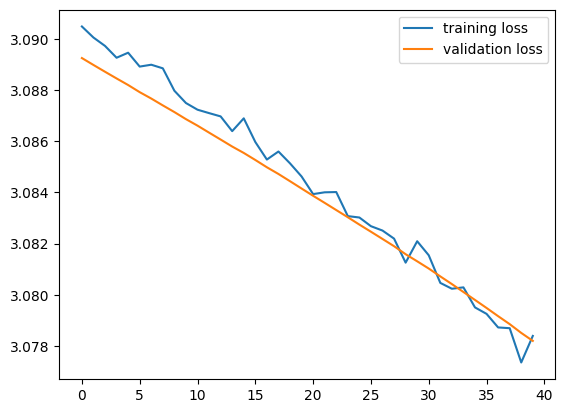

In [ ]:
plt.plot(train_loss_values, label='training loss')
plt.plot(val_loss_values, label='validation loss')
plt.legend()

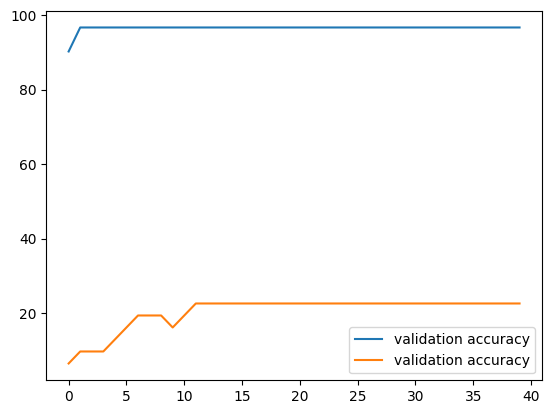

In [ ]:
plt.plot(acc_values, label='validation accuracy')
plt.legend()